# Diffusion + WGAN experiments
This is the main script for experiments related to combining diffusion with
WGAN-based loss within the same training loop.

In [ ]:
# imports

# pretend we are in the root folder:
import sys
sys.path.append("../")

from udl_2024_package.datasets import dataset_factory
from udl_2024_package.nn import unet_factory
from udl_2024_package.vincent_diffusion import DiffusionModel

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, MNIST

import lightning as L

/home/vincent/miniforge3/envs/pytorch_base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development
Will paste stuff above once it works :-)

In [2]:
# Creating the datasets:

trainset, testset = dataset_factory(CIFAR10)

batch_size = 32
dl_kwargs = {
    "batch_size": batch_size, "shuffle": True, "num_workers": 4, "pin_memory": True,
}

trainloader = DataLoader(
    trainset, **dl_kwargs
)
testloader = DataLoader(
    testset, **dl_kwargs
)

In [3]:
# Creating the model:

model = DiffusionModel(
    unet_factory()
)

In [ ]:
# Training the model:


# Setting up the trainer
trainer = L.Trainer(
    max_time={"minutes": 5},
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True
)

trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name   | Type            | Params | Mode 
---------------------------------------------------
0 | model  | DiffusersUnet   | 35.7 M | train
1 | noiser | DiffusionNoiser | 0      | train
---------------------------------------------------
35.7 M    Trainable params
0         Non-trainable params
35.7 M    Total params
142.985   Total estimated model params size (MB)
267       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/vincent/miniforge3/envs/pytorch_base/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 0:  95%|█████████▌| 1489/1563 [04:59<00:14,  4.96it/s, train/mse=0.066] 

Time limit reached. Elapsed time is 0:05:00. Signaling Trainer to stop.


Epoch 0:  95%|█████████▌| 1490/1563 [05:20<00:15,  4.65it/s, train/mse=0.026]


# Sanity check

In [1]:
from diffusers import DDPMScheduler

In [2]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [4]:

# imports

# pretend we are in the root folder:
import os
import sys
sys.path.append("../")

from udl_2024_package.nn import unet_factory, DiffusionNoiser
from udl_2024_package.vincent_diffusion import DiffusionModel
from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms

import torch
from torchvision import datasets
from torch.utils.data import DataLoader

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb



# WandB config:
project_name = "udl_2025_diffusion_gan"
group_name = "experiment_01_wgan_model"

config = {
    # Input data and training:
    "batch_size": 8,          # Warning: change to 256 for real run
    
    "dataset_cls": datasets.CIFAR10,
        "ds_name": "cifar10",   # Warning: change when changing dataset
        "num_channels": 3,      # Warning: change when changing dataset
        "img_size": 32,         # Warning: change when changing dataset
        "extra_transforms": [], # Warning: change when changing dataset

    # "dataset_cls": datasets.MNIST,
    #     "ds_name": "mnist",     # Warning: change when changing dataset
    #     "num_channels": 1,      # Warning: change when changing dataset
    #     "img_size": 32,         # Warning: change when changing dataset
    #     "extra_transforms": [   # Warning: change when changing dataset
    #         transforms.Resize(32)
    #     ],

    "max_epochs": 150,
    "dl_num_workers": 4,

    # WGAN model (WGAN-GP paper defaults):
    "optimizer_cls": torch.optim.Adam,
    "optimizer_args": { "lr": 1e-4, "betas": (0.5, 0.99) },
    "gp_weight": 10,
    "critic_iterations": 5,

    # U-Net config:
    "block_out_channels": [128, 256, 256, 256],
    "layers_per_block": 2,

    # Critic config:
}

datasets_path = "./datasets"

dataloader_kwargs = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": config["dl_num_workers"],
    "pin_memory": True,
}

ds_transforms = default_img_transforms(
    config["num_channels"], config["extra_transforms"])

train_ds = config["dataset_cls"](datasets_path, transform=ds_transforms, download=True, train=True)
val_ds   = config["dataset_cls"](datasets_path, transform=ds_transforms, download=True, train=False)

train_ds = remove_dataset_labels(train_ds)
val_ds   = remove_dataset_labels(val_ds)

train_dl = DataLoader(train_ds, **dataloader_kwargs)
val_dl   = DataLoader(val_ds, **dataloader_kwargs)

In [7]:
batch = next(iter(train_dl))
print(batch.shape)

torch.Size([8, 3, 32, 32])


In [9]:
noise = torch.randn_like(batch)
ts = torch.randint(0, 1000, (8,))
print(noise.shape, ts.shape, ts.dtype)

torch.Size([8, 3, 32, 32]) torch.Size([8]) torch.int64


In [ ]:
noised = noise_scheduler.add_noise(batch, noise, ts)
print(noised.shape)

torch.Size([8, 3, 32, 32])


In [11]:
my_noiser = DiffusionNoiser(1000)
noised_2 = my_noiser.closed_form_noise(batch, noise, ts)
print(noised_2.shape)

torch.Size([8, 3, 32, 32])


In [13]:
torch.all(noised == noised_2)

tensor(True)

# Trying some more stuff

In [36]:
from diffusers import UNet2DModel
from udl_2024_package.vincent_diffusion import DiffusionModel
from types import MethodType

from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline

model_id = "google/ddpm-cifar10-32"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id)
unet = ddpm.unet

# unet = UNet2DModel.from_pretrained("google/ddpm-cifar10-32")

unet.forward2 = unet.forward
def new_forward(self, *args, **kwargs):
    return self.forward2(*args, **kwargs).sample
unet.forward = MethodType(new_forward, unet)

model = DiffusionModel(unet)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
model.to("cuda")

samples = model.sample_img((4, 3, 32, 32))
samples.shape

torch.Size([4, 3, 32, 32])

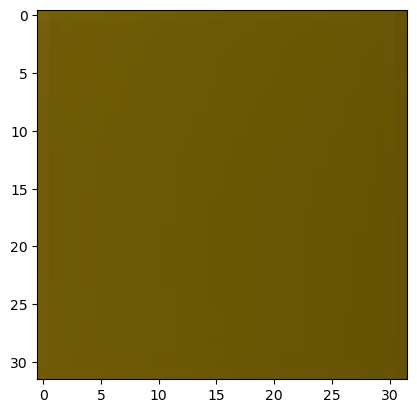

In [43]:
import matplotlib.pyplot as plt

sample = samples[3].detach().cpu() * 0.5 + 0.5
sample = sample.transpose(0,2)
plt.imshow(sample)
plt.show()

In [3]:
# Trying some stuff out

# pretend we are in the root folder:
import os
import sys
sys.path.append("../")

from udl_2024_package.nn import unet_factory, DiffusionNoiser
from udl_2024_package.vincent_diffusion import DiffusionModel
from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from diffusers import UNet2DModel

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb

# WandB config:
project_name = "udl_2025_diffusion_gan"
group_name = "experiment_00_pure_diffusion"

config = {
    # Input data and training:
    "batch_size": 256,          # Warning: change to 256 for real run
    
    "dataset_cls": datasets.CIFAR10,
        "ds_name": "cifar10",   # Warning: change when changing dataset
        "num_channels": 3,      # Warning: change when changing dataset
        "img_size": 32,         # Warning: change when changing dataset
        "extra_transforms": [], # Warning: change when changing dataset

    # "dataset_cls": datasets.MNIST,
    #     "ds_name": "mnist",     # Warning: change when changing dataset
    #     "num_channels": 1,      # Warning: change when changing dataset
    #     "img_size": 32,         # Warning: change when changing dataset
    #     "extra_transforms": [   # Warning: change when changing dataset
    #         transforms.Resize(32)
    #     ],
    
    "max_epochs": 150,
    "dl_num_workers": 4,

    # Diffusion model (DDPM paper defaults):
    "optimizer_cls": torch.optim.Adam,
    "optimizer_args": {"lr": 2e-4},
    "ddpm_steps": 1000,
    "ddpm_beta_start": 0.0001,
    "ddpm_beta_end": 0.02,

    # U-Net config:
    "block_out_channels": [128, 256, 256, 256],
    "layers_per_block": 2
}

datasets_path = os.path.join(os.environ.get("TMPDIR", os.curdir), "datasets")

dataloader_kwargs = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": config["dl_num_workers"],
    "pin_memory": True,
}

unet = unet_factory(
    img_size=config["img_size"],
    img_channels=config["num_channels"],
    block_out_channels=config["block_out_channels"],
    layers_per_block=config["layers_per_block"]
)

dif_model = DiffusionModel.load_from_checkpoint("./cifar10_peachy-totem-7_epochepoch=94.ckpt",
    model=unet,
    optimizer_cls=config["optimizer_cls"],
    optimizer_args=config["optimizer_args"],
    steps=config["ddpm_steps"],
    beta_start=config["ddpm_beta_start"],
    beta_end=config["ddpm_beta_end"],
)
dif_model.to("cpu");

from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline
import numpy as np

model_id = "google/ddpm-cifar10-32"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference

# dif_model.model.__class__.forward = UNet2DModel.forward
unet.__class__.forward = UNet2DModel.forward
ddpm.unet = unet # dif_model.model

# ddpm.to("cuda")


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:

# run pipeline in inference (sample random noise and denoise)
ddpm.to("cuda")
torch.manual_seed(1996)
np.random.seed(1996)
images = ddpm().images

  0%|          | 0/1000 [00:00<?, ?it/s]

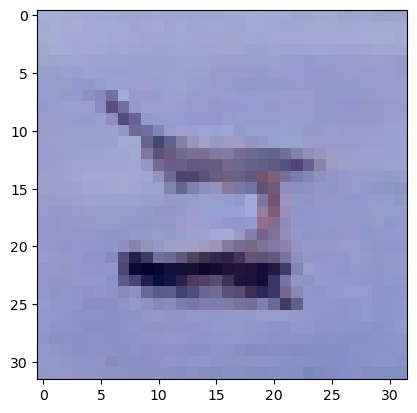

In [9]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.asarray(images[0]))
plt.show()

In [34]:
ddpm.unet

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [35]:
sum(p.numel() for p in ddpm.unet.parameters() if p.requires_grad)

35746307